In [1]:
from dotenv import load_dotenv
from sqlalchemy import Row as sqlRow
from helpers.rpchpostgres import RPChPostgres
from helpers.utils import Utils
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np

%config InlineBackend.figure_format = 'retina'

if load_dotenv():
    print("Environment loaded")
else:
    print("Failed to locate .env file")

Environment loaded


In [2]:
with RPChPostgres() as pg:
    requests = pg.get_xday_data("request_quotas", 60)
    responses = pg.get_xday_data("response_quotas", 60)

Setup connection to PostgreSQL database on 34.65.199.249 as `postgres`
	fetched data from `request_quotas`
	fetched data from `response_quotas`


In [3]:
def calculate_size(row: sqlRow):
    data = "|".join(["4", str(row.id), "0", str(row.segment_count)])
    size = (Utils.utf8len(data) + 400)*(row.segment_count-1)

    if row.last_segment_length is not None:
        size += row.last_segment_length

    return size

request_sizes = list(map(calculate_size, requests))
responses_sizes = list(map(calculate_size, responses))

In [4]:
print(f"Requests:\n\tcount: {len(requests):_}\n\taverage size: {sum(request_sizes)/len(requests):_.2f}")
print(f"Responses:\n\tcount: {len(responses):_}\n\taverage size: {sum(responses_sizes)/len(responses):_.2f}")

Requests:
	count: 1_877_652
	average size: 1_312.59
Responses:
	count: 1_877_666
	average size: 787.90


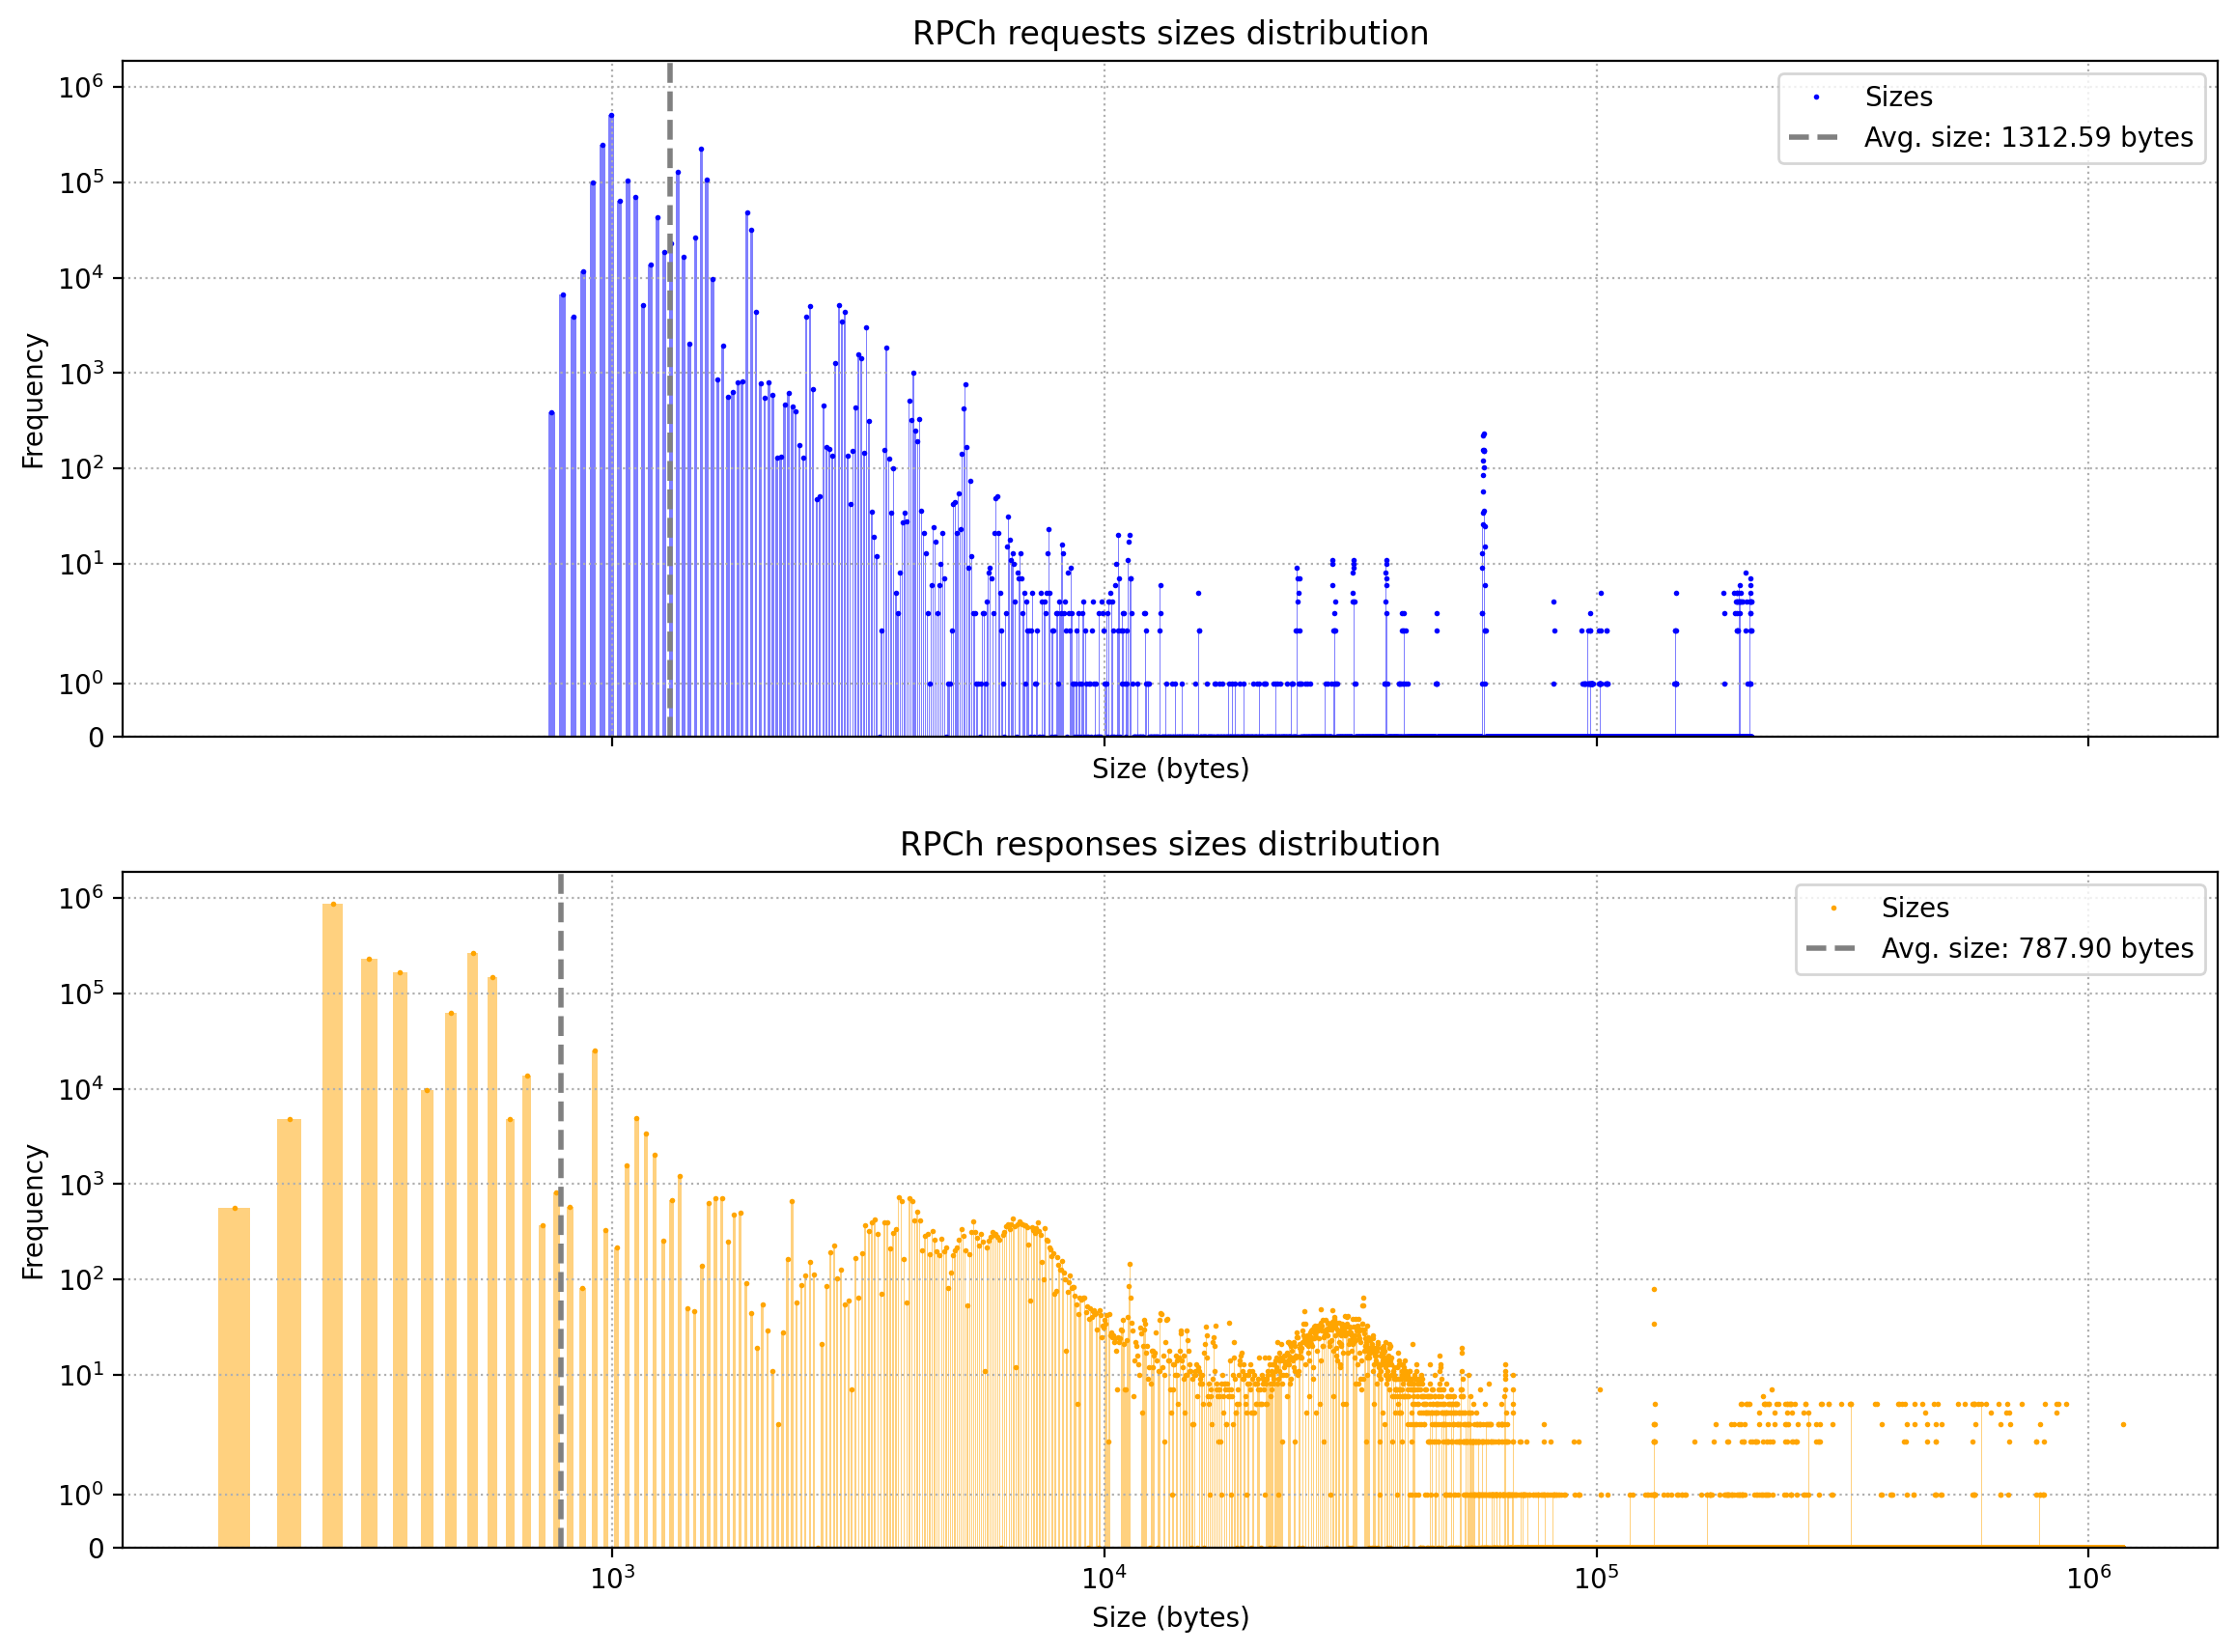

In [5]:
outliars = 0.000001
width = 50

data_dicts = {
    "requests": { "data": request_sizes, "color": "blue" },
    "responses": { "data": responses_sizes, "color": "orange" },
}

_, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, sharey=True)
axes: list[Axes] = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for ax, (key, values) in zip(axes, data_dicts.items()):
    data = values["data"]
    data.sort()

    min_index = 0#int(len(values) * outliars)
    max_index = int(len(data) * (1-outliars))

    value_range = data[max_index]-data[min_index]

    counts, bin_edges = np.histogram(data[min_index:max_index], bins=int(value_range/width))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.

    avg_size = sum(data)/len(data)

    ax.plot(bin_centres, counts, '.', color=values["color"], markersize=2,label="Sizes")
    ax.bar(bin_centres, counts, color=values["color"], width=0.5*width, alpha=0.5)

    ax.axvline(avg_size, color="gray", linestyle='--', linewidth=2, label=f"Avg. size: {avg_size:.2f} bytes")

    ax.set_title(f"RPCh {key} sizes distribution")
    ax.set_xlabel("Size (bytes)")
    ax.set_ylabel("Frequency")
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.grid(True, which="both", ls=":")
    ax.legend()

plt.show()

In [6]:
Utils.dumpSnapshot(rpch_requests_60d=request_sizes, rpch_responses_60d=responses_sizes)